# Billionaire Dataset - Predictive Modelling

This notebook focuses on building predictive models to estimate billionaire wealth based on demographic, geographic, industry, and economic factors.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.feature_engineering import create_advanced_features

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFECV, SelectFromModel

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading
Loading and exploring basic structure of data

In [2]:
# Load data
df = pd.read_csv('../data/processed/df_cleaned.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (2591, 30)


,position,wealth,industry,full_name,age,country_of_residence,city_of_residence,source,citizenship,gender,...,gdp_country,g_tertiary_ed_enroll,g_primary_ed_enroll,life_expectancy,tax_revenue,tax_rate,country_pop,country_lat,country_long,continent
0,1,211000,Fashion & Retail,Bernard Arnault & family,74,France,Paris,LVMH,France,M,...,2715518274227,65.6,102.5,82.5,24.2,60.7,67059887,46.227638,2.213749,Europe
1,2,180000,Automotive,Elon Musk,51,United States,Austin,"Tesla, SpaceX",United States,M,...,21427700000000,88.2,101.8,78.5,9.6,36.6,328239523,37.090240,-95.712891,North America
2,3,114000,Technology,Jeff Bezos,59,United States,Medina,Amazon,United States,M,...,21427700000000,88.2,101.8,78.5,9.6,36.6,328239523,37.090240,-95.712891,North America
3,4,107000,Technology,Larry Ellison,78,United States,Lanai,Oracle,United States,M,...,21427700000000,88.2,101.8,78.5,9.6,36.6,328239523,37.090240,-95.712891,North America
4,5,106000,Finance & Investments,Warren Buffett,92,United States,Omaha,Berkshire Hathaway,United States,M,...,21427700000000,88.2,101.8,78.5,9.6,36.6,328239523,37.090240,-95.712891,North America


## 2. Data Preparation
Preparing data for modelling by defining features and splitting data into training and test sets

In [15]:
# Define features and log transform the target
df = create_advanced_features(df)

# Convert cpi_country to numeric
df['cpi_country_numeric'] = pd.to_numeric(df['cpi_country'], errors='coerce')

# Select features based on availability in the dataset
numeric_features = ['age', 'gdp_country', 'country_pop', 'cpi_country_numeric', 
                    'g_tertiary_ed_enroll', 'life_expectancy', 'tax_revenue', 
                    'wealth_to_gdp_ratio', 'log_gdp', 'log_country_pop', 
                    'gdp_per_capita', 'career_years', 'wealth_per_year']
categorical_features = ['gender', 'industry', 'continent']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[numeric_features + categorical_features],
    df['log_wealth'],
    test_size=0.2,
    random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (2072, 16)
Test set shape: (519, 16)


## 3. Preprocessing Pipeline
Creating a preprocessing pipeline to handle numeric and categorical features

In [17]:
# Define preprocessing for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create preprocessing pipeline
print("Preprocessing pipeline created.")

# Add feature selection to identify most predictive features
feature_selector = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median'))
])

# Fit selector on training data
feature_selector.fit(X_train, y_train)

# Get selected feature indices
selected_features = feature_selector.named_steps['selector'].get_support()

# Print selected features
all_features = numeric_features + list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
selected_feature_names = [feature for feature, selected in zip(all_features, selected_features) if selected]
print(f"Selected features: {selected_feature_names}")

Preprocessing pipeline created.
Selected features: ['age', 'gdp_country', 'country_pop', 'cpi_country_numeric', 'g_tertiary_ed_enroll', 'life_expectancy', 'tax_revenue', 'wealth_to_gdp_ratio', 'log_gdp', 'log_country_pop', 'gdp_per_capita', 'career_years', 'wealth_per_year', 'industry_Automotive', 'industry_Fashion & Retail', 'industry_Finance & Investments', 'industry_Food & Beverage', 'industry_Manufacturing', 'industry_Technology', 'continent_Europe']


## 4. Model Building and Evaluation
Train and evaluate multiple regression models

Linear Regression Results:
MSE: 0.37
RMSE: 0.61
MAE: 0.50
R² Score: 0.3666
--------------------------------------------------
Ridge Regression Results:
MSE: 0.38
RMSE: 0.62
MAE: 0.51
R² Score: 0.3534
--------------------------------------------------
Random Forest Results:
MSE: 0.00
RMSE: 0.05
MAE: 0.02
R² Score: 0.9958
--------------------------------------------------
Gradient Boosting Results:
MSE: 0.00
RMSE: 0.06
MAE: 0.04
R² Score: 0.9937
--------------------------------------------------


,Model,MSE,RMSE,MAE,R²
2,Random Forest,0.002475,0.049746,0.022235,0.995796
3,Gradient Boosting,0.003724,0.061025,0.035976,0.993674
0,Linear Regression,0.372849,0.610613,0.503023,0.366643
1,Ridge Regression,0.380620,0.616944,0.507153,0.353442


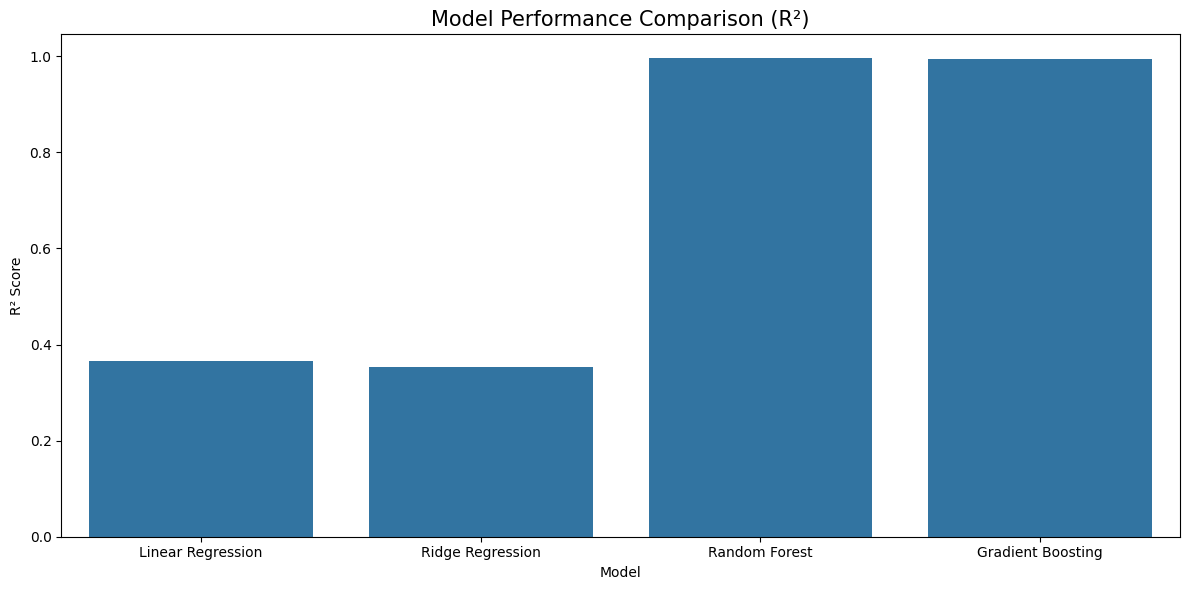

In [18]:
# Evaluate model method
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 50)
    
    return {
        'model': model,
        'model_name': model_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    }

# Create and evaluate Linear Regression model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_results = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test, "Linear Regression")

# Create and evaluate Ridge Regression model
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])
ridge_results = evaluate_model(ridge_pipeline, X_train, X_test, y_train, y_test, "Ridge Regression")

# Create and evaluate Random Forest model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_results = evaluate_model(rf_pipeline, X_train, X_test, y_train, y_test, "Random Forest")

# Create and evaluate Gradient Boosting model
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])
gb_results = evaluate_model(gb_pipeline, X_train, X_test, y_train, y_test, "Gradient Boosting")

# Compare model performance
models = [lr_results, ridge_results, rf_results, gb_results]
results_df = pd.DataFrame({
    'Model': [model['model_name'] for model in models],
    'MSE': [model['mse'] for model in models],
    'RMSE': [model['rmse'] for model in models],
    'MAE': [model['mae'] for model in models],
    'R²': [model['r2'] for model in models]
})

display(results_df.sort_values('RMSE'))

# Visualize model performance comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R²', data=results_df)
plt.title('Model Performance Comparison (R²)', fontsize=15)
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()

## 5. Feature Importance
Analyzing feature importance for the best performed model

,Feature,Importance
12,wealth_per_year,0.834602
0,age,0.079407
11,career_years,0.075231
7,wealth_to_gdp_ratio,0.006026
3,cpi_country_numeric,0.000680
6,tax_revenue,0.000600
5,life_expectancy,0.000503
9,log_country_pop,0.000401
10,gdp_per_capita,0.000329
2,country_pop,0.000279


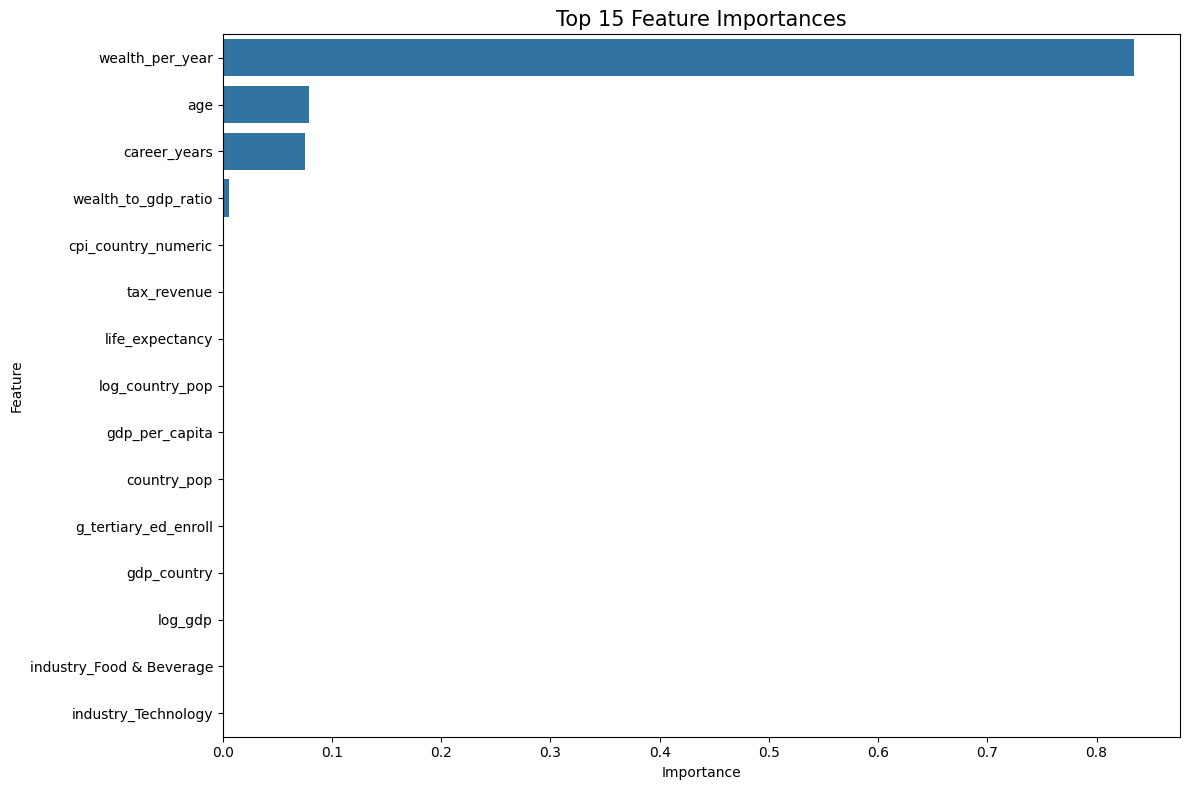

In [20]:
# Above analysis indicates that Random Forest performed best
best_model = rf_pipeline

# Get feature names after preprocessing
preprocessor = best_model.named_steps['preprocessor']

# Fit the preprocessor to get feature names
preprocessor.fit(X_train)

# Get feature names from OneHotEncoder
all_feature_names = []

# Get numeric feature names
numeric_transformer = preprocessor.transformers_[0][1]
numeric_columns = preprocessor.transformers_[0][2]
all_feature_names.extend(numeric_columns)


# Get categorical feature names
categorical_transformer = preprocessor.transformers_[1][1]
categorical_columns = preprocessor.transformers_[1][2]
cat_encoder = categorical_transformer.named_steps['onehot']
encoded_features = cat_encoder.get_feature_names_out(categorical_columns)
all_feature_names.extend(encoded_features)

# Get feature importances
rf_model = best_model.named_steps['regressor']
importances = rf_model.feature_importances_

# Create DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Display top 15 important features
display(feature_importance_df.head(15))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances', fontsize=15)
plt.tight_layout()
plt.show()